In [1]:
%matplotlib inline
import sys, os
from pathlib import Path

# for reading mat files
import scipy.io
import h5py

# array computations
import numpy as np
import xarray as xr

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# BIOQIC phantom MRE data

In [9]:
def print_mat_info(d, level=0, tab=' '*4):
    for k, v in d.items():
        if hasattr(v, 'shape'):
            print(tab*level + f'{k}: {type(v)} {v.shape} {v.dtype}')
        else:
            print(tab*level + f'{k}: {type(v)}')
        if hasattr(v, 'items'):
            print_mat_info(v, level+1)

def load_mat_data(mat_file, verbose=True):
    try:
        data = scipy.io.loadmat(mat_file)
    except NotImplementedError as e:
        # Please use HDF reader for matlab v7.3 files
        data = h5py.File(mat_file)
    if verbose:
        print_mat_info(data)
    return data

repo_dir = Path('/ocean/projects/asc170022p/mtragoza/mre-siren')
data_dir = repo_dir / 'data' / 'BIOQIC'
os.chdir(data_dir)
%ls

phantom_raw.mat          phantom_unwrapped.mat
phantom_raw_complex.mat  phantom_unwrapped_dejittered.mat


In [10]:
data_raw = load_mat_data('phantom_raw.mat')

#refs#: <class 'h5py._hl.group.Group'>
    #a#: <class 'h5py._hl.dataset.Dataset'> (24, 1) uint16
    #b#: <class 'h5py._hl.dataset.Dataset'> (27, 1) uint16
    #c#: <class 'h5py._hl.dataset.Dataset'> (26, 1) uint16
    #d#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
    #e#: <class 'h5py._hl.dataset.Dataset'> (39, 1) uint16
    #f#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
info: <class 'h5py._hl.group.Group'>
    dx_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dy_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dz_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    frequencies_Hz: <class 'h5py._hl.dataset.Dataset'> (8, 1) float64
    index_description: <class 'h5py._hl.dataset.Dataset'> (1, 6) object
    size: <class 'h5py._hl.dataset.Dataset'> (6, 1) float64
magnitude: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64
phase: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64


In [12]:
data_unw = load_mat_data('phantom_unwrapped.mat')

#refs#: <class 'h5py._hl.group.Group'>
    #a#: <class 'h5py._hl.dataset.Dataset'> (24, 1) uint16
    #b#: <class 'h5py._hl.dataset.Dataset'> (27, 1) uint16
    #c#: <class 'h5py._hl.dataset.Dataset'> (26, 1) uint16
    #d#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
    #e#: <class 'h5py._hl.dataset.Dataset'> (39, 1) uint16
    #f#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
info: <class 'h5py._hl.group.Group'>
    dx_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dy_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dz_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    frequencies_Hz: <class 'h5py._hl.dataset.Dataset'> (8, 1) float64
    index_description: <class 'h5py._hl.dataset.Dataset'> (1, 6) object
    size: <class 'h5py._hl.dataset.Dataset'> (6, 1) float64
magnitude: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64
phase_unwrapped: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64


In [13]:
data_dej = load_mat_data('phantom_unwrapped_dejittered.mat')

__header__: <class 'bytes'>
__version__: <class 'str'>
__globals__: <class 'list'>
info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64


In [14]:
data_com = load_mat_data('phantom_raw_complex.mat')

__header__: <class 'bytes'>
__version__: <class 'str'>
__globals__: <class 'list'>
cube: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) complex128
voxelsizem: <class 'numpy.ndarray'> (1, 3) float64
frequenciesHz: <class 'numpy.ndarray'> (1, 8) uint8


# Convert phantom data to xarray dataset

In [51]:
%%time

# metadata from pdf doc applies to all data
metadata = dict(
    dims=['freq', 'MEG', 't', 'z', 'x', 'y'],
    coords=dict(
        freq=[30, 40, 50, 60, 70, 80, 90, 100],
        MEG=['y', 'x', 'z']
    )
)

# create xarray dataset from downloaded files
ds = xr.Dataset(dict(
    magni_raw = xr.DataArray(data_raw['magnitude'], **metadata),
    phase_raw = xr.DataArray(data_raw['phase'], **metadata),
    magni_unwrap = xr.DataArray(data_unw['magnitude'], **metadata),
    phase_unwrap = xr.DataArray(data_unw['phase_unwrapped'], **metadata),
    magni_dejit = xr.DataArray(data_dej['magnitude'].transpose(range(6)[::-1]).astype(np.float64), **metadata),
    phase_dejit = xr.DataArray(data_dej['phase_unwrap_noipd'].transpose(range(6)[::-1]), **metadata),
    cube_real = xr.DataArray(data_com['cube'].real.transpose(range(6)[::-1]), **metadata),
    cube_imag = xr.DataArray(data_com['cube'].imag.transpose(range(6)[::-1]), **metadata)
))
ds

CPU times: user 5.81 s, sys: 535 ms, total: 6.35 s
Wall time: 6.36 s


<xarray.Dataset>
Dimensions:       (freq: 8, MEG: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * freq          (freq) int64 30 40 50 60 70 80 90 100
  * MEG           (MEG) <U1 'y' 'x' 'z'
Dimensions without coordinates: t, z, x, y
Data variables:
    magni_raw     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_raw     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 1.364 2.938
    magni_unwrap  (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_unwrap  (freq, MEG, t, z, x, y) float64 4.695e-09 ... -3.346
    magni_dejit   (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_dejit   (freq, MEG, t, z, x, y) float64 -0.6366 -1.153 ... -3.561
    cube_real     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 8.43 -76.38
    cube_imag     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 40.12 15.8

In [52]:
# descriptive statistics
ds.to_dataframe().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
magni_raw,49152000.0,313.954245,233.221729,0.000000,59.000000,425.000000,522.000000,2796.000000
phase_raw,49152000.0,-0.044564,1.586261,-3.141593,-1.199573,-0.069029,1.107534,3.141593
magni_unwrap,49152000.0,313.954245,233.221729,0.000000,59.000000,425.000000,522.000000,2796.000000
phase_unwrap,49152000.0,0.930254,13.145816,-382.237333,-1.587671,0.194816,3.152331,394.452422
magni_dejit,49152000.0,313.954245,233.221729,0.000000,59.000000,425.000000,522.000000,2796.000000
phase_dejit,49152000.0,0.930749,10.594018,-293.254524,-1.548938,0.181480,2.932810,302.263166
cube_real,49152000.0,96.242596,270.731862,-2297.871142,-33.276906,32.139456,327.953198,2686.298212
cube_imag,49152000.0,-14.195944,264.952338,-2729.929769,-128.081800,-3.900401,79.083353,2302.279826


In [ ]:
# TODO write out xarray dataset

# Visualize the phantom data

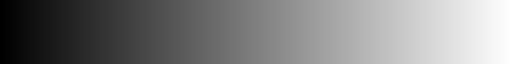

In [53]:
# create magnitude color map
magni_colors = [(0,0,0), (1,1,1)]
magni_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='magnitude', colors=magni_colors, N=255
)
magni_cmap

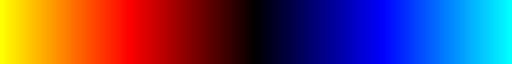

In [54]:
# create phase color map
phase_colors = [(1,1,0), (1,0,0), (0,0,0), (0,0,1), (0,1,1)]
phase_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='phase', colors=phase_colors, N=255
)
phase_cmap

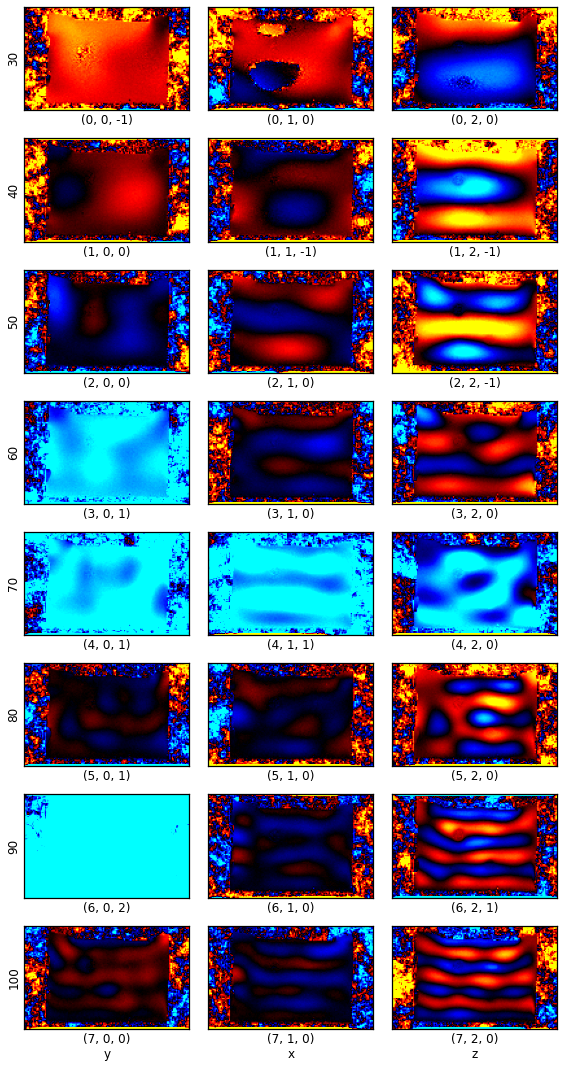

In [49]:
# recreate the sample image
fig, axes = plt.subplots(8, 3, figsize=(8, 15))

if False:
    data = ds['magni_raw']
    cmap = magni_cmap
    v_min, v_max = (0, 2796)
else:
    data = ds['phase_unwrap']
    cmap = phase_cmap
    v_min, v_max = (-2*np.pi, 2*np.pi)

for i in range(8):
    for j in range(3):
        
        ax = axes[i,j]
        im = np.array(data[i,j,0,0,:,:].T)
        
        # estimate the phase shift
        phase_shift = int(np.round(im.mean()/(2*np.pi)))
        #im -= phase_shift * 2 *np.pi
        
        ax.imshow(im, cmap=cmap, vmin=v_min, vmax=v_max)
        xlabel = f'({i}, {j}, {phase_shift})'

        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(data.coords['freq'][i].values)
        if i == 7:
            xlabel += '\n' + str(data.coords['MEG'][j].values)
        ax.set_xlabel(xlabel)

fig.tight_layout()